In [2]:
from google import colab
colab.drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DATA_PATH = "/content/drive/MyDrive/data/jobcare/"
SUBMIT_PATH = "/content/drive/MyDrive/data/jobcare/submit/"
SEED = 0

In [4]:
!pip install catboost
!pip install bayesian-optimization

     |████████████████████████████████| 76.1 MB 46.9 MB/s 
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=a3af7857723dfbd0a1252253540f74bf5f2e613a15c8bc7c193fda1b1f124a8b
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [5]:
import os
import sys
import random
import math
from typing import List ,Dict, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
from sklearn.model_selection import StratifiedKFold , KFold
from sklearn.metrics import f1_score 

from catboost import Pool,CatBoostClassifier
from bayes_opt import BayesianOptimization

%matplotlib inline

In [6]:
train_data = pd.read_csv(f'{DATA_PATH}train.csv')
test_data = pd.read_csv(f'{DATA_PATH}test.csv')

d_code = pd.read_csv(f'{DATA_PATH}속성_D_코드.csv', index_col=0).T.to_dict()
h_code = pd.read_csv(f'{DATA_PATH}속성_H_코드.csv', index_col=0).T.to_dict()
l_code = pd.read_csv(f'{DATA_PATH}속성_L_코드.csv', index_col=0).T.to_dict()

In [ ]:
train_data.shape

(501951, 35)

In [ ]:
d_code.get(4)

{'속성 D 대분류코드': 1, '속성 D 세분류코드': 4, '속성 D 소분류코드': 3, '속성 D 중분류코드': 2}

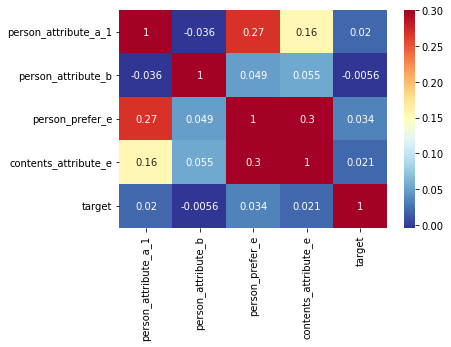

In [ ]:
sns.heatmap(train_data[['person_attribute_a_1', 'person_attribute_b', 'person_prefer_e', 'contents_attribute_e', 'target']].corr(method='spearman'),cmap = plt.cm.RdYlBu_r, annot=True, vmin=-0.0040, vmax = 0.3)

In [ ]:
# train_data['weekday'] = 
datet = pd.DatetimeIndex(train_data['contents_open_dt'])
# train_data['weekday'] = [x.dayofweek for x in datet]

In [10]:
def add_code(df, d_code, h_code, l_code):
    df = df.copy()   
    # D Code
    df['person_prefer_d_1_n'] = df['person_prefer_d_1'].apply(lambda x: d_code[x]['속성 D 세분류코드'])
    df['person_prefer_d_1_s'] = df['person_prefer_d_1'].apply(lambda x: d_code[x]['속성 D 소분류코드'])
    df['person_prefer_d_1_m'] = df['person_prefer_d_1'].apply(lambda x: d_code[x]['속성 D 중분류코드'])
    df['person_prefer_d_1_l'] = df['person_prefer_d_1'].apply(lambda x: d_code[x]['속성 D 대분류코드'])

    df['person_prefer_d_2_n'] = df['person_prefer_d_2'].apply(lambda x: d_code[x]['속성 D 세분류코드'])
    df['person_prefer_d_2_s'] = df['person_prefer_d_2'].apply(lambda x: d_code[x]['속성 D 소분류코드'])
    df['person_prefer_d_2_m'] = df['person_prefer_d_2'].apply(lambda x: d_code[x]['속성 D 중분류코드'])
    df['person_prefer_d_2_l'] = df['person_prefer_d_2'].apply(lambda x: d_code[x]['속성 D 대분류코드'])

    df['person_prefer_d_3_n'] = df['person_prefer_d_3'].apply(lambda x: d_code[x]['속성 D 세분류코드'])
    df['person_prefer_d_3_s'] = df['person_prefer_d_3'].apply(lambda x: d_code[x]['속성 D 소분류코드'])
    df['person_prefer_d_3_m'] = df['person_prefer_d_3'].apply(lambda x: d_code[x]['속성 D 중분류코드'])
    df['person_prefer_d_3_l'] = df['person_prefer_d_3'].apply(lambda x: d_code[x]['속성 D 대분류코드'])

    df['contents_attribute_d_n'] = df['contents_attribute_d'].apply(lambda x: d_code[x]['속성 D 세분류코드'])
    df['contents_attribute_d_s'] = df['contents_attribute_d'].apply(lambda x: d_code[x]['속성 D 소분류코드'])
    df['contents_attribute_d_m'] = df['contents_attribute_d'].apply(lambda x: d_code[x]['속성 D 중분류코드'])
    df['contents_attribute_d_l'] = df['contents_attribute_d'].apply(lambda x: d_code[x]['속성 D 대분류코드'])

    # H Code
    df['person_prefer_h_1_l'] = df['person_prefer_h_1'].apply(lambda x: h_code[x]['속성 H 대분류코드'])
    df['person_prefer_h_1_m'] = df['person_prefer_h_1'].apply(lambda x: h_code[x]['속성 H 중분류코드'])
    
    df['person_prefer_h_2_l'] = df['person_prefer_h_2'].apply(lambda x: h_code[x]['속성 H 대분류코드'])
    df['person_prefer_h_2_m'] = df['person_prefer_h_2'].apply(lambda x: h_code[x]['속성 H 중분류코드'])
    
    df['person_prefer_h_3_l'] = df['person_prefer_h_3'].apply(lambda x: h_code[x]['속성 H 대분류코드'])
    df['person_prefer_h_3_m'] = df['person_prefer_h_3'].apply(lambda x: h_code[x]['속성 H 중분류코드'])

    df['contents_attribute_h_l'] = df['contents_attribute_h'].apply(lambda x: h_code[x]['속성 H 대분류코드'])
    df['contents_attribute_h_m'] = df['contents_attribute_h'].apply(lambda x: h_code[x]['속성 H 중분류코드'])

    # L Code
    df['contents_attribute_l_n'] = df['contents_attribute_l'].apply(lambda x: l_code[x]['속성 L 세분류코드'])
    df['contents_attribute_l_s'] = df['contents_attribute_l'].apply(lambda x: l_code[x]['속성 L 소분류코드'])
    df['contents_attribute_l_m'] = df['contents_attribute_l'].apply(lambda x: l_code[x]['속성 L 중분류코드'])
    df['contents_attribute_l_l'] = df['contents_attribute_l'].apply(lambda x: l_code[x]['속성 L 대분류코드'])
    
    return df

def preprocess_data(
                    df:pd.DataFrame,is_train:bool = True  , cols_equi:List[Tuple[str,str]]= [] ,
                    cols_drop:List[str] = ["id","person_prefer_f","person_prefer_g" ,"contents_open_dt"]
                    )->Tuple[pd.DataFrame,np.ndarray]:
    df = df.copy()

    y_data = None
    if is_train:
        y_data = df["target"].to_numpy()
        df = df.drop(columns="target")

    # for col, df_code in cols_merge:
    #     df = merge_codes(df,df_code,col)
    df = add_code(df, d_code, h_code, l_code)

    cols = df.select_dtypes(bool).columns.tolist()
    df[cols] = df[cols].astype(int)

    for col1, col2 in cols_equi:
        df[f"{col1}_{col2}"] = (df[col1] == df[col2] ).astype(int)

    df = df.drop(columns=cols_drop)
    return (df , y_data)

In [11]:
# 회원 속성과 콘텐츠 속성의 동일한 코드 여부에 대한 컬럼명 리스트
cols_equi = [

    ("contents_attribute_c","person_prefer_c"),
    ("contents_attribute_e","person_prefer_e"),

    ("person_prefer_d_2_s" , "contents_attribute_d_s"),
    ("person_prefer_d_2_m" , "contents_attribute_d_m"),
    ("person_prefer_d_2_l" , "contents_attribute_d_l"),
    ("person_prefer_d_3_s" , "contents_attribute_d_s"),
    ("person_prefer_d_3_m" , "contents_attribute_d_m"),
    ("person_prefer_d_3_l" , "contents_attribute_d_l"),

    ("person_prefer_h_1_m" , "contents_attribute_h_m"),
    ("person_prefer_h_2_m" , "contents_attribute_h_m"),
    ("person_prefer_h_3_m" , "contents_attribute_h_m"),
    ("person_prefer_h_1_l" , "contents_attribute_h_l"),
    ("person_prefer_h_2_l" , "contents_attribute_h_l"),
    ("person_prefer_h_3_l" , "contents_attribute_h_l"),

]

# 학습에 필요없는 컬럼 리스트
cols_drop = ["id","person_prefer_f","person_prefer_g" ,"contents_open_dt", "contents_rn", ]

In [13]:
x_train, y_train = preprocess_data(train_data , cols_equi= cols_equi , cols_drop = cols_drop)
x_test, _ = preprocess_data(test_data,is_train = False,  cols_equi= cols_equi  , cols_drop = cols_drop)
x_train.shape , y_train.shape , x_test.shape

((501951, 71), (501951,), (46404, 71))

In [74]:
x_train.head()

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_1,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,person_prefer_d_1_n,person_prefer_d_1_s,person_prefer_d_1_m,person_prefer_d_1_l,person_prefer_d_2_n,person_prefer_d_2_s,person_prefer_d_2_m,person_prefer_d_2_l,person_prefer_d_3_n,person_prefer_d_3_s,person_prefer_d_3_m,person_prefer_d_3_l,contents_attribute_d_n,contents_attribute_d_s,contents_attribute_d_m,contents_attribute_d_l,person_prefer_h_1_l,person_prefer_h_1_m,person_prefer_h_2_l,person_prefer_h_2_m,person_prefer_h_3_l,person_prefer_h_3_m,contents_attribute_h_l,contents_attribute_h_m,contents_attribute_l_n,contents_attribute_l_s,contents_attribute_l_m,contents_attribute_l_l,contents_attribute_c_person_prefer_c,contents_attribute_e_person_prefer_e,person_prefer_d_2_s_contents_attribute_d_s,person_prefer_d_2_m_contents_attribute_d_m,person_prefer_d_2_l_contents_attribute_d_l,person_prefer_d_3_s_contents_attribute_d_s,person_prefer_d_3_m_contents_attribute_d_m,person_prefer_d_3_l_contents_attribute_d_l,person_prefer_h_1_m_contents_attribute_h_m,person_prefer_h_2_m_contents_attribute_h_m,person_prefer_h_3_m_contents_attribute_h_m,person_prefer_h_1_l_contents_attribute_h_l,person_prefer_h_2_l_contents_attribute_h_l,person_prefer_h_3_l_contents_attribute_h_l
0,1,1,1,0,0,0,1,4,3,5,275,370,369,8,4,95,59,3,3,10,2,1,2,1608,275,1,4,139,618822,275,274,274,216,369,368,297,216,369,368,297,216,275,274,274,216,3,316,94,398,58,368,94,422,1607,1606,1605,2016,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,0,0,0,1,1,0,1,3,4,1,114,181,175,4,131,101,96,1,3,5,1,1,2,1608,275,1,4,133,571659,114,109,56,1,175,152,56,1,175,152,56,1,275,274,274,216,94,417,94,400,94,399,94,417,1607,1606,1605,2016,1,1,0,0,0,0,0,0,1,0,0,1,1,1
2,0,0,0,1,0,0,2,0,3,5,464,175,452,3,54,263,56,3,1,10,2,1,1,1600,94,1,4,53,399816,464,463,450,377,175,152,56,1,452,451,450,377,92,91,56,1,48,364,250,528,48,366,48,363,1599,1595,1572,2016,0,0,0,1,1,0,0,0,0,0,0,1,0,1
3,0,0,0,1,0,0,2,0,2,5,703,705,704,3,72,227,2,1,3,5,1,1,2,1608,275,5,3,74,827967,703,703,690,618,703,703,690,618,703,703,690,618,275,274,274,216,71,379,226,495,1,315,71,381,1607,1606,1605,2016,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,1,1,1,0,0,0,1,3,4,5,275,370,369,4,214,210,209,1,1,10,2,1,2,1608,275,1,4,74,831614,275,274,274,216,369,368,297,216,369,368,297,216,275,274,274,216,208,483,208,481,208,480,71,381,1607,1606,1605,2016,0,1,0,0,1,0,0,1,0,0,0,0,0,0


In [14]:
ord_features = ['person_attribute_a_1', 'person_attribute_b', 'person_prefer_e', 'contents_attribute_e']
cat_features = x_train.columns[x_train.nunique() > 2].tolist()
cat_features = [x for x in cat_features if x not in ord_features]

In [77]:
cat_features

['person_prefer_c',
 'person_prefer_d_1',
 'person_prefer_d_2',
 'person_prefer_d_3',
 'person_prefer_h_1',
 'person_prefer_h_2',
 'person_prefer_h_3',
 'contents_attribute_i',
 'contents_attribute_a',
 'contents_attribute_j_1',
 'contents_attribute_c',
 'contents_attribute_l',
 'contents_attribute_d',
 'contents_attribute_m',
 'contents_attribute_h',
 'person_rn',
 'person_prefer_d_1_n',
 'person_prefer_d_1_s',
 'person_prefer_d_1_m',
 'person_prefer_d_1_l',
 'person_prefer_d_2_n',
 'person_prefer_d_2_s',
 'person_prefer_d_2_m',
 'person_prefer_d_2_l',
 'person_prefer_d_3_n',
 'person_prefer_d_3_s',
 'person_prefer_d_3_m',
 'person_prefer_d_3_l',
 'contents_attribute_d_n',
 'contents_attribute_d_s',
 'contents_attribute_d_m',
 'contents_attribute_d_l',
 'person_prefer_h_1_l',
 'person_prefer_h_1_m',
 'person_prefer_h_2_l',
 'person_prefer_h_2_m',
 'person_prefer_h_3_l',
 'person_prefer_h_3_m',
 'contents_attribute_h_l',
 'contents_attribute_h_m',
 'contents_attribute_l_n',
 'contents_

In [ ]:
x_train.columns[x_train.nunique() <= 2].tolist()

['d_l_match_yn',
 'd_m_match_yn',
 'd_s_match_yn',
 'h_l_match_yn',
 'h_m_match_yn',
 'h_s_match_yn',
 'person_attribute_a',
 'contents_attribute_j',
 'contents_attribute_k',
 'contents_attribute_c_person_prefer_c',
 'contents_attribute_e_person_prefer_e',
 'person_prefer_d_2_s_contents_attribute_d_s',
 'person_prefer_d_2_m_contents_attribute_d_m',
 'person_prefer_d_2_l_contents_attribute_d_l',
 'person_prefer_d_3_s_contents_attribute_d_s',
 'person_prefer_d_3_m_contents_attribute_d_m',
 'person_prefer_d_3_l_contents_attribute_d_l',
 'person_prefer_h_1_m_contents_attribute_h_m',
 'person_prefer_h_2_m_contents_attribute_h_m',
 'person_prefer_h_3_m_contents_attribute_h_m',
 'person_prefer_h_1_l_contents_attribute_h_l',
 'person_prefer_h_2_l_contents_attribute_h_l',
 'person_prefer_h_3_l_contents_attribute_h_l']

In [15]:
is_holdout = False
n_splits = 5
iterations = 3000
patience = 50

pbounds = {"depth": (2,7),
           "learning_rate": (.01, 0.2),
           "subsample":(0.6, 1.),
           "num_leaves": (16,40),
           "max_bin":(150,300),
           "l2_leaf_reg":(0,10),
           "model_size_reg": (0,10)
}

scores = []
models = []

In [16]:
def CB_opt(depth, learning_rate, max_bin,
             subsample, num_leaves, l2_leaf_reg, model_size_reg):
  cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
  scores = []
  models = []
  for tri, vai in cv.split(x_train, y_train):
      # print("="*50)
      preds = []

      model = CatBoostClassifier(iterations=iterations,random_state=SEED,task_type="GPU",eval_metric="F1",
                                learning_rate=learning_rate, cat_features=cat_features,one_hot_max_size=4,
                                use_best_model = True,grow_policy = "Lossguide",
                                 subsample = subsample, 
                                 max_bin = int(max_bin),  
                                 model_size_reg = model_size_reg,
                                 max_depth = int(depth),
                                 num_leaves = int(num_leaves),
                                 l2_leaf_reg = l2_leaf_reg,
                                 verbose = 0,
                                 bootstrap_type='Poisson'
      )

      model.fit(x_train.iloc[tri], y_train[tri], 
              eval_set=[(x_train.iloc[vai], y_train[vai])], 
              early_stopping_rounds=patience ,
          )
      
      models.append(model)
      scores.append(model.get_best_score()["validation"]["F1"])
      if is_holdout:
          break

  return np.mean(scores)

In [ ]:
optimizer = BayesianOptimization(
    f = CB_opt,
    pbounds = pbounds,
    verbose = 2,
    random_state = 888,
)

optimizer.maximize(init_points = 2, n_iter = 20)

print(optimizer.max)

|   iter    |  target   |   depth   | l2_lea... | learni... |  max_bin  | model_... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

|  1        |  0.6662   |  6.298    |  1.646    |  0.1019   |  288.2    |  4.286    |  17.38    |  0.97     |
|  2        |  0.6663   |  5.288    |  1.33     |  0.1114   |  284.9    |  2.484    |  16.72    |  0.629    |
|  3        |  0.6601   |  2.082    |  3.697    |  0.1237   |  207.0    |  5.492    |  33.68    |  0.7119   |
|  4        |  0.6239   |  2.0      |  10.0     |  0.01     |  270.0    |  10.0     |  40.0     |  0.6      |
|  5        |  0.6649   |  5.875    |  0.5282   |  0.0466   |  173.1    |  4.524    |  29.92    |  0.9124   |
|  6        |  0.6177   |  2.0      |  10.0     |  0.2      |  150.0    |  10.0     |  40.0     |  1.0      |
|  7        |  0.6514   |  7.0      |  0.0      |  0.01     |  188.8    |  0.1223   |  18.41    |  0.9381   |
|  8        |  0.6291   |  2.0      |  0.0      |  0.01     |  187.1    |  10.0     |  40.0     |  0.6      |
|  9        |  0.6177   |  7.0      |  0.0      |  0.01     |  169.5    |  0.0      |  19.27    |  1.0      |
|  10     

In [17]:
# params = optimizer.max['params']
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
scores = []
models = []
for tri, vai in cv.split(x_train, y_train):
    print("="*50)
    preds = []

    model = CatBoostClassifier(iterations=iterations,random_state=SEED,task_type="GPU",eval_metric="F1",
                              cat_features=cat_features,one_hot_max_size=4,
                              # grow_policy = "Lossguide",
                                subsample = 0.9, 
                                # max_bin = int(params['max_bin']), 
                                # model_size_reg = params['model_size_reg'],
                                # max_depth = int(params['depth']),
                                # num_leaves = int(params['num_leaves']),
                                l2_leaf_reg = 0.01,
                                verbose = 100,
                                bootstrap_type='Poisson'
    )

    model.fit(x_train.iloc[tri], y_train[tri], 
            eval_set=[(x_train.iloc[vai], y_train[vai])], 
            early_stopping_rounds=patience ,
        )
    
    models.append(model)
    scores.append(model.get_best_score()["validation"]["F1"])

CatBoostError: ignored

In [1]:
print(scores)
print(np.mean(scores))

NameError: ignored

In [ ]:
for threshold in np.arange(0.35,0.45,0.1):
  pred_list = []
  scores = []
  for i,(tri, vai) in enumerate( cv.split(x_train,y_train) ):
      pred = models[i].predict_proba(x_train.iloc[vai])[:, 1]
      pred = np.where(pred >= threshold , 1, 0)
      score = f1_score(y_train[vai],pred)
      scores.append(score)
      pred = models[i].predict_proba(x_test)[:, 1]
      pred_list.append(pred)
  print(scores)
  print(np.mean(scores))

In [ ]:
pred = np.mean( pred_list , axis = 0 )
pred = np.where(pred >= threshold , 1, 0)

In [ ]:
sample_submission = pd.read_csv(f'{DATA_PATH}sample_submission.csv')
sample_submission['target'] = pred

In [ ]:
sample_submission.to_csv(f"{SUBMIT_PATH}prediction.csv", index=False)